# Failure Category Cluster using Unsupervised ML
This is the last step before the Machine Learning training

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import preprocessing

In [4]:
## Define a window processing function

# result = slide_window_fft(fft_size, data, fs, overlap_fac)
def slide_window_fft(data, fft_size, fs, overlap_fac):
    data = data.flatten()
    hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
    pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
    total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
    t_max = len(data) / np.float32(fs)

    window = np.hanning(fft_size)  # our half cosine window
    inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

    proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
    result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result

    for i in range(total_segments):                      # for each segment
        current_hop = hop_size * i                        # figure out the current segment offset
        segment = proc[current_hop:current_hop+fft_size]  # get the current segment
        windowed = segment * window                       # multiply by the half cosine function
        padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
        spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
        autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
        result[i, :] = autopower[:fft_size]               # append to the results array
    
    result = 20*np.log10(result)          # scale to db
    return result


In [14]:
npzfile = np.load('CWRU_cleaned.npz')
df_time = pd.DataFrame()
df_fft = pd.DataFrame()
category_labels = ['Normal','Ball 0.007 inch', 'Ball 0.014 inch', 'Ball 0.021 inch', 
                  'Inner race 0.007 inch', 'Inner race 0.014 inch', 'Inner race 0.021 inch',
                  'Outer race 0.007 inch', 'Outer race 0.014 inch', 'Outer race 0.021 inch']

res = dict(zip(npzfile.files, category_labels))

#todo first drop na for df_time
#second scale the data after it was done

for fi in npzfile.files:
    # time data 
    df = pd.DataFrame(npzfile[fi], columns=[res[fi]])
#     df['labels'] = res[fi]
    df_time = pd.concat([df_time, df], axis = 1)

df_time.dropna(axis = 0,inplace=True)
df_time_scaled = pd.DataFrame(preprocessing.scale(df_time), columns=df_time.columns)
print(df_time_scaled)


          Normal  Ball 0.007 inch  Ball 0.014 inch  Ball 0.021 inch  \
0       0.519166        -0.429365        -3.376357        -0.352299   
1      -0.757243        -0.465417        -3.463821        -0.236117   
2      -1.560197        -0.337731        -3.053186        -0.142775   
3      -1.489819        -0.124421        -2.313448         0.034972   
4      -0.779636         0.109921        -1.300942         0.178957   
...          ...              ...              ...              ...   
381885  1.283731         1.090849        -0.675353         0.304075   
381886  1.101387         1.951603        -0.826562         0.822422   
381887  0.122487         2.565998        -0.835456         1.320909   
381888 -0.648477         2.786819        -0.872517         1.628739   
381889 -0.539710         2.526941        -0.915508         1.739955   

        Inner race 0.007 inch  Inner race 0.014 inch  Inner race 0.021 inch  \
0                    0.040835              -0.109786               1

In [33]:
fft_size = 4000
fs = 1/48000
overlap_fac = 0.01
freq = 1/(fft_size*fs)*np.linspace(0,fft_size-1,fft_size) # frequency axis

for col in df_time.columns:
    # fft data
    result = slide_window_fft(df_time[col].values, fft_size, fs, overlap_fac)
    df = pd.DataFrame(result, columns=freq)
    df['labels'] = col
    df_fft = pd.concat([df_fft, df], axis = 0)
    
# print(df_fft)

### prepare for PCA

In [46]:
df_fft.columns

Index([     0.0,     12.0,     24.0,     36.0,     48.0,     60.0,     72.0,
           84.0,     96.0,    108.0,
       ...
        47892.0,  47904.0,  47916.0,  47928.0,  47940.0,  47952.0,  47964.0,
        47976.0,  47988.0, 'labels'],
      dtype='object', length=4001)

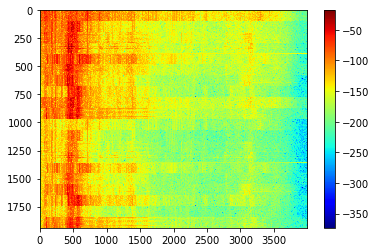

In [44]:
# result = preprocessing.MaxAbsScaler().fit_transform(result)
img = plt.imshow(df_fft.drop('labels',axis = 1).values, cmap='jet', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

## PCA

In [36]:
fault_type = pd.Categorical(df_fft['labels']).rename_categories(category_labels)

Text(0.5, 1.0, 'Result of PCA without data scaling')

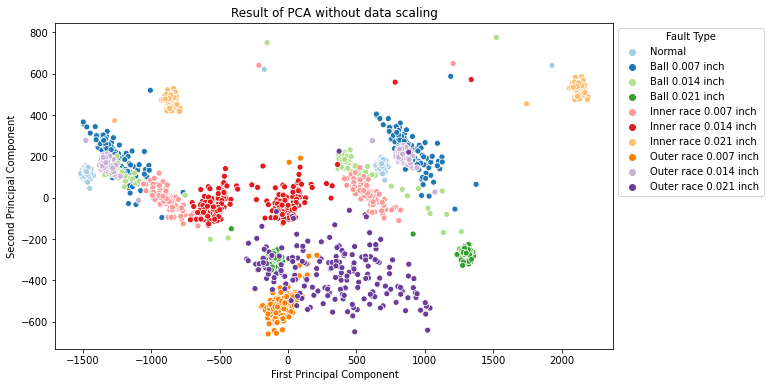

In [38]:
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns
# for time
pca_res = sklearn.decomposition.PCA(n_components= 2, random_state= 1).fit_transform(df_fft.drop('labels',axis = 1))

plt.figure(figsize=(10,6))
sns.scatterplot(
        x=pca_res[:,0], y= pca_res[:,1],
        hue=fault_type,
        palette=sns.color_palette("Paired",10),
        data=pd.DataFrame(pca_res))
plt.legend(bbox_to_anchor=(1, 1), loc=2, title = "Fault Type")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Result of PCA without data scaling")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Text(0.5, 1.0, 'Result of PCA after data scaling')

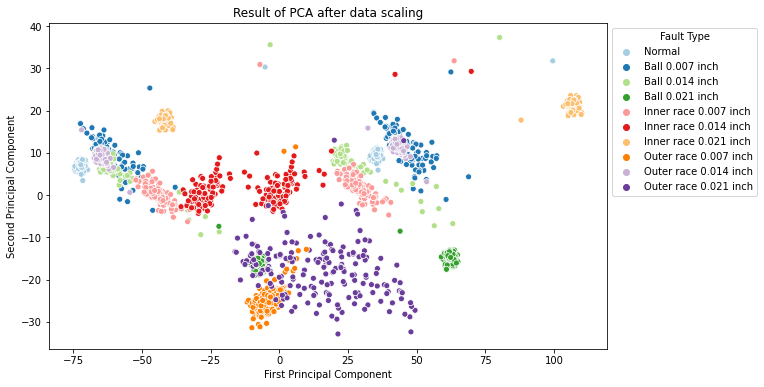

In [39]:
scaled_data = preprocessing.scale(df_fft.drop('labels',axis = 1)) 

pca_scaled_res = sklearn.decomposition.PCA(n_components=2, random_state = 2).fit_transform(scaled_data)
plt.figure(figsize=(10,6))
sns.scatterplot(
        x=pca_scaled_res[:,0], y= pca_scaled_res[:,1],
        hue=fault_type,
        palette=sns.color_palette("Paired",10),
        data=pd.DataFrame(pca_scaled_res))
plt.legend(bbox_to_anchor=(1, 1), loc=2, title = "Fault Type")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Result of PCA after data scaling")

## Kernel PCA

Text(0.5, 1.0, 'Result of KPCA on scaled data')

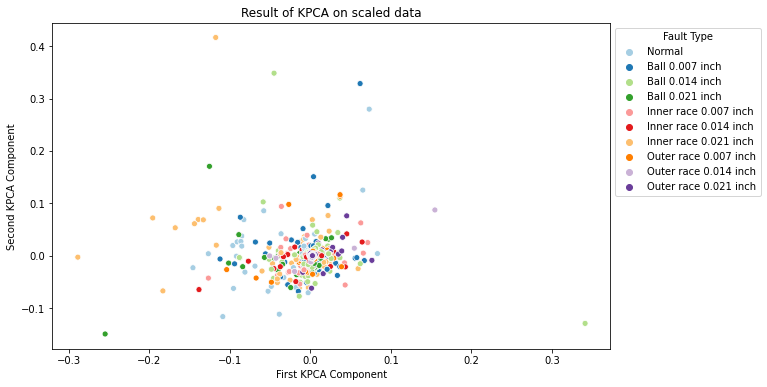

In [41]:
ker_pca_res = sklearn.decomposition.KernelPCA(
    n_components=2,kernel="rbf",gamma = 0.5,random_state=3).fit_transform(
    df_fft.drop('labels',axis = 1))

plt.figure(figsize=(10,6))
sns.scatterplot(
        x=ker_pca_res[:,0], y= ker_pca_res[:,1],
        hue=fault_type,
        palette=sns.color_palette("Paired",10),
        data=pd.DataFrame(ker_pca_res))
plt.legend(bbox_to_anchor=(1, 1), loc=2, title = "Fault Type")
plt.xlabel("First KPCA Component")
plt.ylabel("Second KPCA Component")
plt.title("Result of KPCA on scaled data")

## t-SNE

Text(0.5, 1.0, 'Result of t-SNE on scaled data')

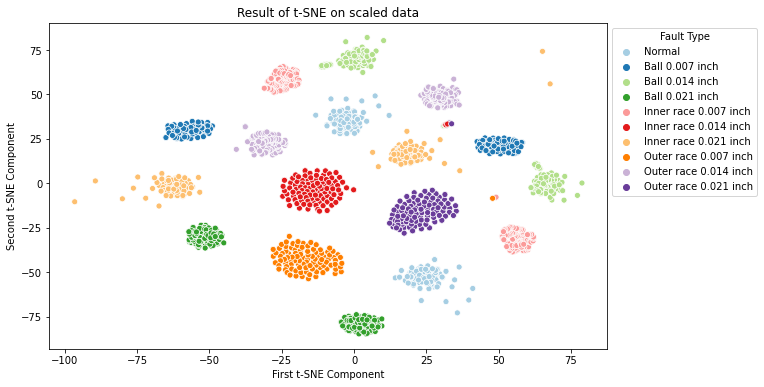

In [43]:
from sklearn.manifold import TSNE
tsne_res = TSNE(n_components=2,random_state=4).fit_transform(df_fft.drop('labels',axis = 1))
plt.figure(figsize=(10,6))
sns.scatterplot(
        x=tsne_res[:,0], y= tsne_res[:,1],
        hue=fault_type,
        palette=sns.color_palette("Paired",10),
        data=pd.DataFrame(tsne_res))
plt.legend(bbox_to_anchor=(1, 1), loc=2, title = "Fault Type")
plt.xlabel("First t-SNE Component")
plt.ylabel("Second t-SNE Component")
plt.title("Result of t-SNE on scaled data")